In [1]:
#Author: Jason Slover
#Adapted from:
# RMA SAR algorithm written by Gregory L. Charvat as part of his dissertation:
# G. L. Charvat, ``A Low-Power Radar Imaging System," Ph.D. dissertation,
# Dept. of Electrical and Computer Engineering, Michigan State University, East Lansing, MI, 2007.
# 
# Please cite appropriately.  
# 
# This algorithm was based on:
# Range Migration Algorithm from ch 10 of Spotlight Synthetic Aperture Radar
# Signal Processing Algorithms, Carrara, Goodman, and Majewski

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from scipy.io import wavfile
from scipy.io import loadmat #Just used to compare outputs with matlab 
from scipy.signal import hilbert
#%qtconsole

In [2]:
start=time.time()
def toc(): #This will help me not modify the code as much from the original matlab
    return time.time()-start
print('Program running, clock at %f seconds' %toc())
fs, data=wavfile.read('sar1motioninfield.wav') #Sampling frequency, 2-channel data
print('Audioread completed at %f seconds' %toc())

#Define constant
c=299792458.0 #(m/s) speed of light
#Define radar parameters
T_p = 20e-3 #(s) Time length of pulse
Trp = .25 #Minimum range profile time duration
num_samp = int(np.floor(T_p*fs))
fstart = 2260e6 #(Hz) LFM start frequency
fstop = 2590e6 #(Hz) LFM stop frequency
BW = fstop-fstart #(Hz) transmit bandwidth

freq= np.linspace(fstart,fstop,num_samp//2) #instantaneous transmit frequency

#Invert the input... why I have no idea
#Matlab autonormalizes and python doesn't, divide by 32767
trig_channel=-1*data[:,0]/32767
data_channel=-1*data[:,1]/32767
print('Input inversion completed at %f seconds' %toc())

#Parse data here by position (silence between recorded data)
#I don't like the way they did this and I think it could be much faster
rpstart=np.abs(trig_channel)>np.mean(np.abs(trig_channel))

No_data_length=int(np.floor(Trp*fs))
rpstart[0]=True
where_rp=rpstart.nonzero()[0]
diff_rp=where_rp[1:]-where_rp[:-1]
trigger_thresh=diff_rp>No_data_length
npulses=np.sum(trigger_thresh) #Count the number of transmitter locations
trigger_start=trigger_thresh.nonzero()[0]
location_start=where_rp[trigger_start+1]

data_parsed_loc=np.zeros((npulses,No_data_length))
trig_parsed_loc=np.zeros((npulses,No_data_length))
for i in range(npulses):
    data_parsed_loc[i,:]=data_channel[location_start[i]:location_start[i]+No_data_length]
    trig_parsed_loc[i,:]=trig_channel[location_start[i]:location_start[i]+No_data_length]
print('Parsed by position at %f seconds' %toc())

#Parse data by pulse, add coherant pulses
thresh=0.08
sif3=np.zeros((npulses,num_samp//2))+0*1j
phase_hist=np.zeros((npulses,num_samp))
test=np.zeros((npulses,100))
for i in range(npulses):
    loc=trig_parsed_loc[i,:]
    dat=data_parsed_loc[i,:]
    loc_threshed=loc>thresh
    loc_thresh=(loc_threshed).nonzero()[0]
    loc_diff=loc_thresh[1:]-loc_thresh[:-1]
    loc_diff_index=(loc_diff>9).nonzero()[0]
    #loc_start=np.concatenate((np.array([0]),loc_diff))
    loc_start=loc_thresh[loc_diff_index+1]
    pulse=np.zeros(num_samp)
    chopped=0
    for pul in loc_start[loc_start<(len(loc)-2*num_samp)]:
        max_loc=np.argmax(loc[pul:pul+2*num_samp])
        max_here=np.argmax(loc[pul:pul+2])
        if max_loc==max_here:
            clip=dat[pul+max_loc:pul+max_loc+num_samp]
            pulse=pulse+clip
            test[i,chopped]=pul+max_here
            chopped=chopped+1
    
    phase_hist[i,:]=pulse/chopped
    # They say this is the hilbert transform, I don't see why
    q=np.fft.ifft(pulse/chopped)
    sif3[i,:]=np.fft.fft(q[len(q)//2:])
    
#things happen so...
phase_hist[np.isnan(phase_hist)]=1e-30
#sif3=hilbert(phase_hist,axis=1)
sif3[np.isnan(sif3)]=1e-30
halfsamples=sif3.shape[1]

print('SAR data ready at %f seconds' %toc())
end_time=time.time()-start

Program running, clock at 0.000000 seconds
Audioread completed at 0.047873 seconds
Input inversion completed at 0.164385 seconds


C:\Users\jks7592\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Parsed by position at 0.344848 seconds
SAR data ready at 0.344848 seconds


<IPython.core.display.Javascript object>


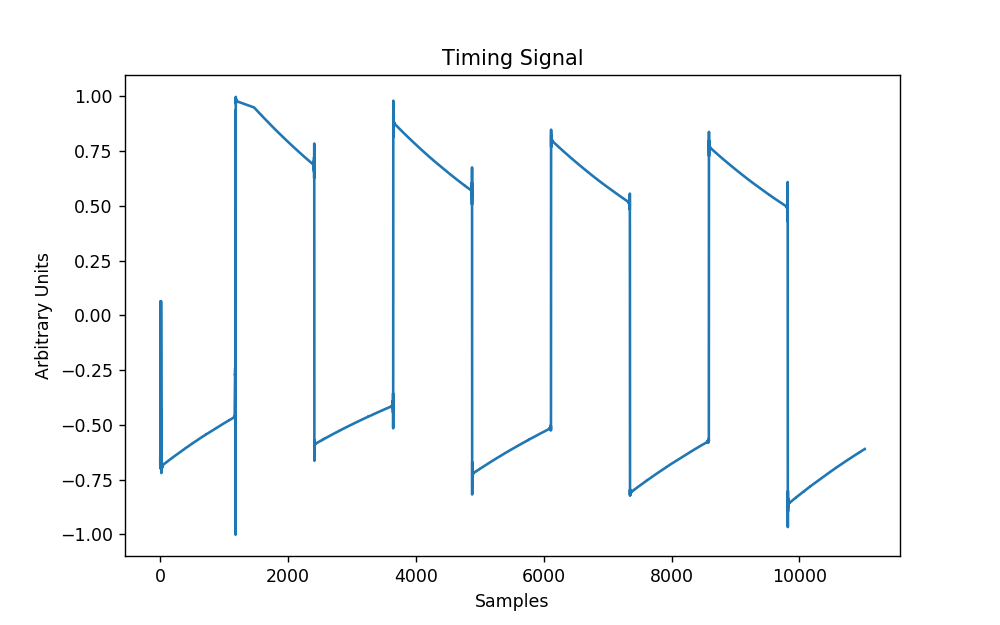

In [4]:
shape=data_parsed_loc.shape
x=range(shape[1])
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(x,trig_parsed_loc[30,:])
ax.set_ylabel('Arbitrary Units')
ax.set_xlabel('Samples')
ax.set_title('Timing Signal')
fig.savefig('Timing Signal')

<IPython.core.display.Javascript object>


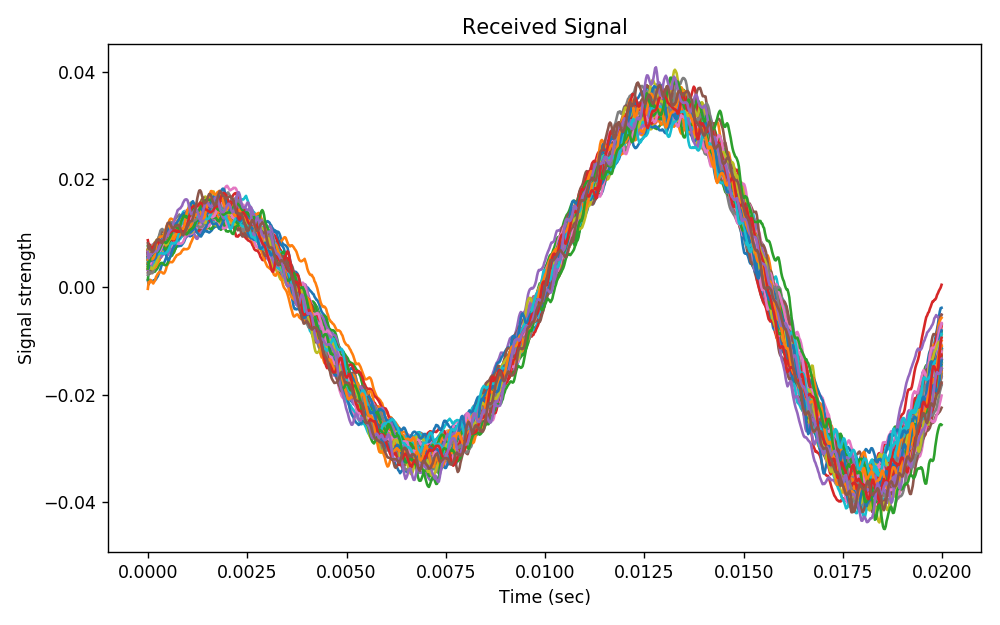

In [5]:
x=(np.arange(num_samp))/fs
y1=phase_hist[0,:]
y2=phase_hist[30,:]
y3=phase_hist[45,:]
def plotme(x,phase_hist,ax):
    for i in np.arange(phase_hist.shape[0]):
        ax.plot(x,phase_hist[i,:])
fig,ax1=plt.subplots(figsize=(8,5))
plotme(x,phase_hist,ax1)
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Signal strength')
ax1.set_title('Received Signal')

fig.tight_layout()
fig.savefig('Received Signal')


<IPython.core.display.Javascript object>


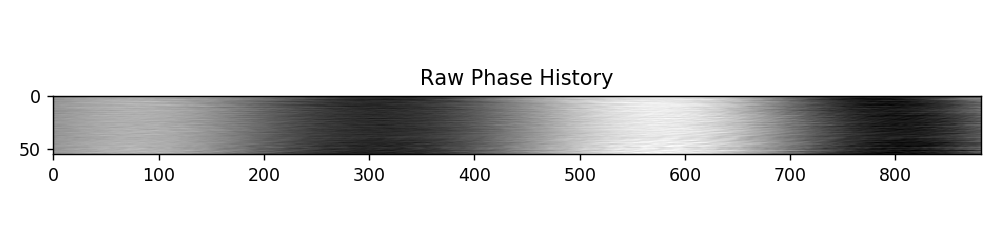

In [99]:
fig,ax=plt.subplots(figsize=(8,2))
ax.imshow(phase_hist,cmap='gray')
ax.set_title('Raw Phase History')
fig.tight_layout()
fig.savefig('Phase_history')

<IPython.core.display.Javascript object>


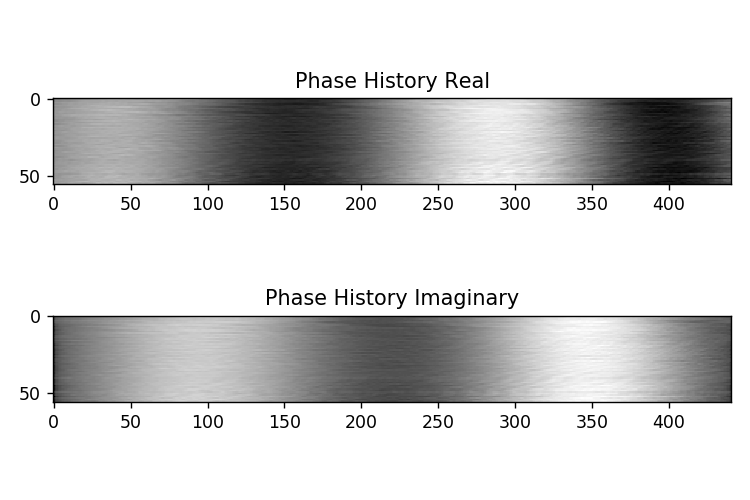

In [145]:
fig,ax=plt.subplots(2,1,figsize=(6,4))
ax[0].imshow(np.real(sif3),cmap='gray')
ax[0].set_title('Phase History Real')
ax[1].imshow(np.imag(sif3),cmap='gray')
ax[1].set_title('Phase History Imaginary')
fig.tight_layout()
fig.savefig('Phase_history_hilbert')

<IPython.core.display.Javascript object>


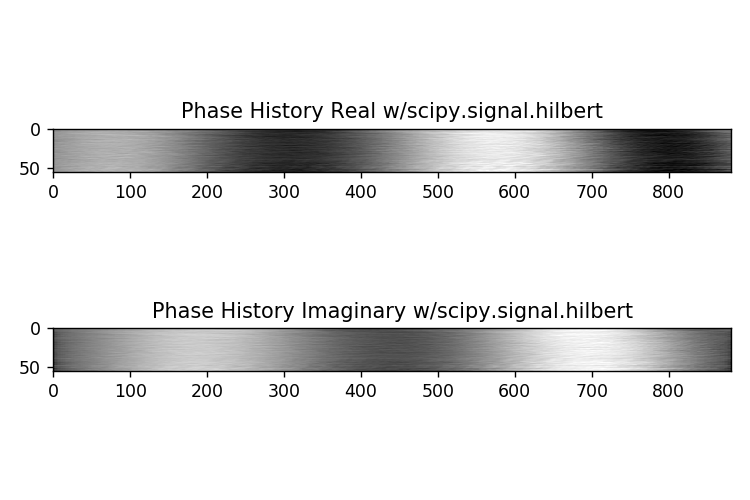

In [156]:
from scipy.signal import hilbert
test=hilbert(phase_hist,axis=1)
fig,ax=plt.subplots(2,1,figsize=(6,4))
ax[0].imshow(np.real(test),cmap='gray')
ax[0].set_title('Phase History Real w/scipy.signal.hilbert')
ax[1].imshow(np.imag(test),cmap='gray')
ax[1].set_title('Phase History Imaginary w/scipy.signal.hilbert')
fig.tight_layout()
fig.savefig('scipyHilbertPhaseHist')

<IPython.core.display.Javascript object>


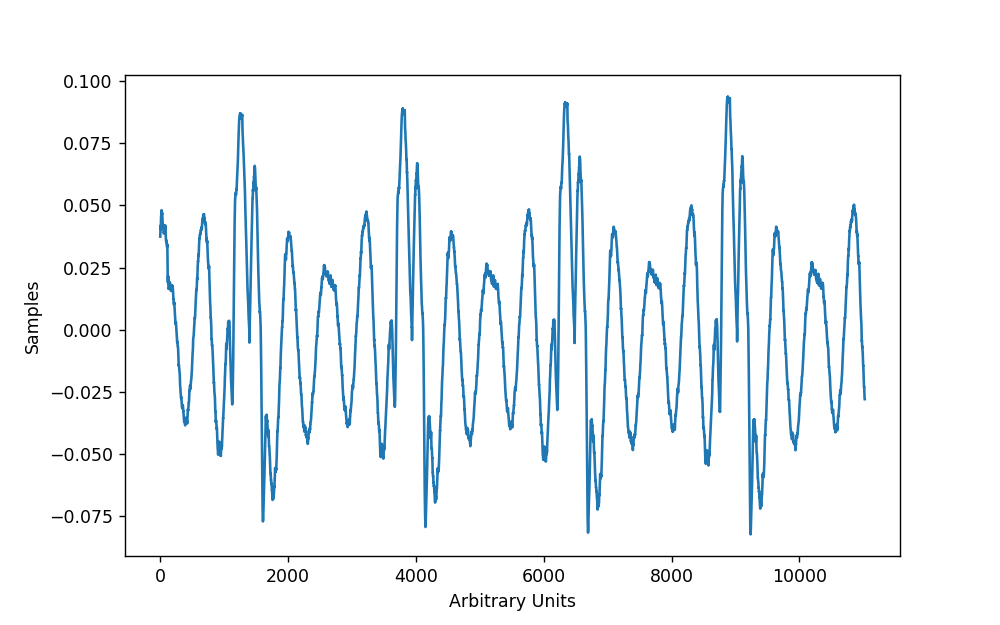

Text(0, 0.5, 'Samples')

In [13]:
shape=data_parsed_loc.shape
x=range(shape[1])
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(x,data_parsed_loc[30,:])
ax.set_xlabel('Arbitrary Units')
ax.set_ylabel('Samples')

In [6]:
start=time.time()-end_time
#Why are they doing this?
# sif2=sif.copy()
# for i in range(npulses):
#     sif2[i,:]=sif2[i,:]-np.mean(sif2,axis=0)[None,:]
#Maybe they are trying to subtract the mean?
s2=sif3-np.mean(sif3,axis=0)[None,:]
    
#radar parameters
fc = (2590e6 - 2260e6)/2 + 2260e6; #(Hz) center radar frequency
B = (2590e6 - 2260e6); #(hz) bandwidth
cr = B/20e-3; #(Hz/sec) chirp rate
Tp = 20e-3; #(sec) pulse width
#VERY IMPORTANT, change Rs to distance to cal target
#Rs = (12+9/12)*.3048; #(m) y coordinate to scene center (down range), make this value equal to distance to cal target
Rs = 0;
Xa = 0; #(m) beginning of new aperture length
delta_x = 2*(1/12)*0.3048; #(m) 2 inch antenna spacing
L = delta_x*(npulses); #(m) aperture length
Xa = np.linspace(-L/2, L/2, int((L/delta_x))); #(m) cross range position of radar on aperture L.............Not used
Za = 0;
Ya = Rs; #THIS IS VERY IMPORTANT, SEE GEOMETRY FIGURE 10.6.... which is why it's never used again!
t = np.linspace(0, Tp, halfsamples); #(s) fast time, CHECK SAMPLE RATE
Kr = np.linspace(((4*np.pi/c)*(fc - B/2)), ((4*np.pi/c)*(fc + B/2)), (len(t)));

print('Phase 1 of processing took %f seconds' %toc())
phase1end=time.time()-start

Phase 1 of processing took 0.345849 seconds


<IPython.core.display.Javascript object>


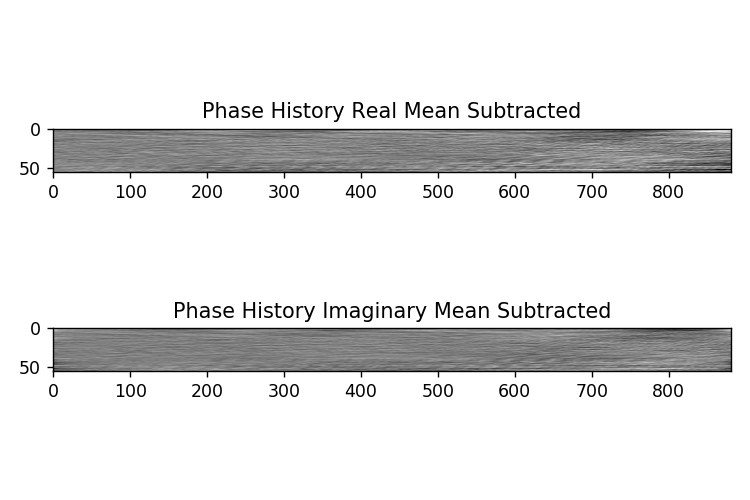

In [158]:
fig,ax=plt.subplots(2,1,figsize=(6,4))
ax[0].imshow(np.real(s2),cmap='gray')
ax[0].set_title('Phase History Real Mean Subtracted')
ax[1].imshow(np.imag(s2),cmap='gray')
ax[1].set_title('Phase History Imaginary Mean Subtracted')
fig.tight_layout()
fig.savefig('Phase_history_Mean_Subtracted')

In [142]:
s2.shape

(60, 441)

<IPython.core.display.Javascript object>


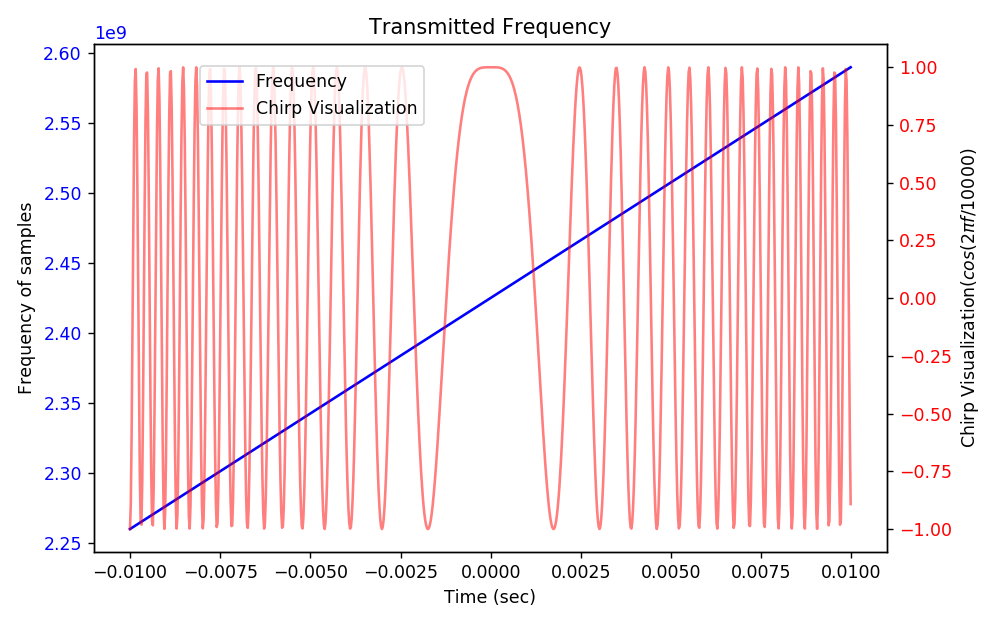

In [10]:
x=(np.arange(num_samp)-num_samp//2)/fs
y=cr*x+fc
fig,ax1=plt.subplots(figsize=(8,5))
ax1.plot(x,y,color='b',label='Frequency')

ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Frequency of samples')
ax1.set_title('Transmitted Frequency')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(x,np.cos(((y-fc)*(2*np.pi/1e5))*x),color='r',alpha=.5,label='Chirp Visualization')
ax2.set_ylabel(r'Chirp Visualization($cos(2\pi f$/10000)')
ax2.tick_params(axis='y', labelcolor='r')
fig.tight_layout()
fig.legend(loc=(.2,.8))
fig.savefig('transFreq')

<IPython.core.display.Javascript object>


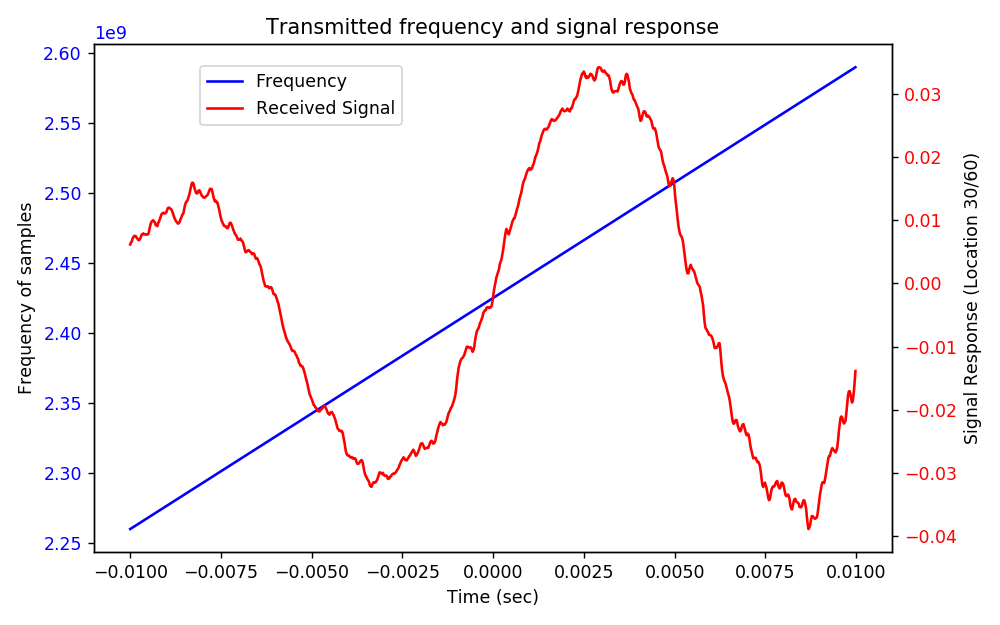

In [7]:
x=(np.arange(num_samp)-num_samp//2)/fs
y=cr*x+fc
fig,ax1=plt.subplots(figsize=(8,5))
ax1.plot(x,y,color='b',label='Frequency')

ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Frequency of samples')
ax1.set_title('Transmitted frequency and signal response')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(x,phase_hist[30,:],color='r',label='Received Signal')
ax2.set_ylabel('Signal Response (Location 30/60)')
ax2.tick_params(axis='y', labelcolor='r')
fig.tight_layout()
fig.legend(loc=(.2,.8))
fig.savefig('transFreqandSigResponse')


In [163]:
start=time.time()-phase1end
#PHASE 2 Processing
sif=s2 #Add optional background processing here

#Apply hanning window
N=sif.shape[1]
H=np.zeros(N)
for ii in range(N):
    H[ii]=.5+.5*np.cos(2*np.pi*(ii+1-N/2)/N)

sif_h=sif*H[None,:]

#%along track FFT (in the slow time domain)
#%first, symetrically cross range zero pad so that the radar can squint
zpad = 2048; #%cross range symetrical zero pad
szeros=np.zeros((zpad,N))+0*1j
index=int(np.ceil((zpad-npulses)/2))
szeros[index:index+npulses,:]=sif_h

S=np.fft.ifftshift(np.fft.fft(np.fft.fftshift(szeros),axis=0))
#S=np.fft.fft(sif_h,n=2048,axis=0)
#S=np.fft.fft(szeros,axis=0)
Kx=np.linspace((-np.pi/delta_x),(np.pi/delta_x),S.shape[0])

print('Along track FFT section complete at %f seconds' %toc())
FFT_time=time.time()-start

Along track FFT section complete at 0.377990 seconds


<IPython.core.display.Javascript object>


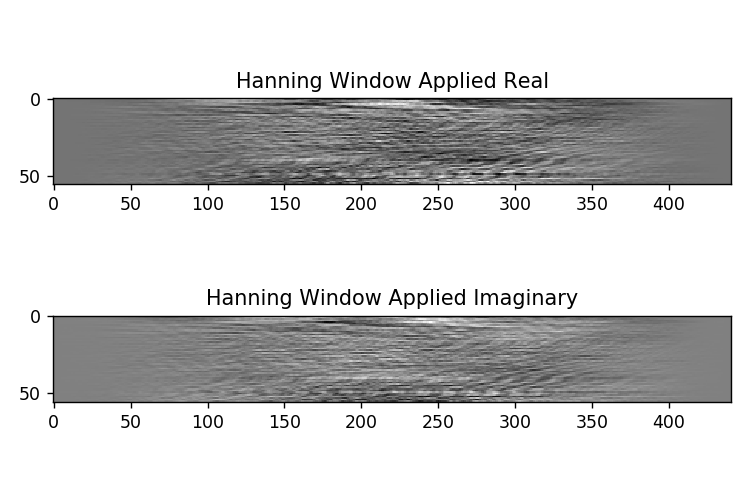

In [165]:
fig,ax=plt.subplots(2,1,figsize=(6,4))
ax[0].imshow(np.real(sif_h),cmap='gray')
ax[0].set_title('Hanning Window Applied Real')
ax[1].imshow(np.imag(sif_h),cmap='gray')
ax[1].set_title('Hanning Window Applied Imaginary')
fig.tight_layout()
fig.savefig('Phase_history_hanning')

<IPython.core.display.Javascript object>


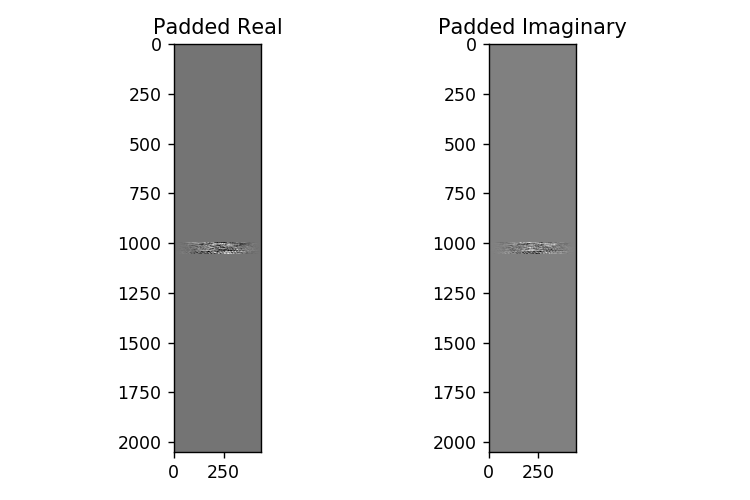

In [172]:
fig,ax=plt.subplots(1,2,figsize=(6,4))
ax[0].imshow(np.real(szeros),cmap='gray')
ax[0].set_title('Padded Real')
ax[1].imshow(np.imag(szeros),cmap='gray')
ax[1].set_title('Padded Imaginary')
fig.tight_layout()
fig.savefig('Padded_history')

<IPython.core.display.Javascript object>


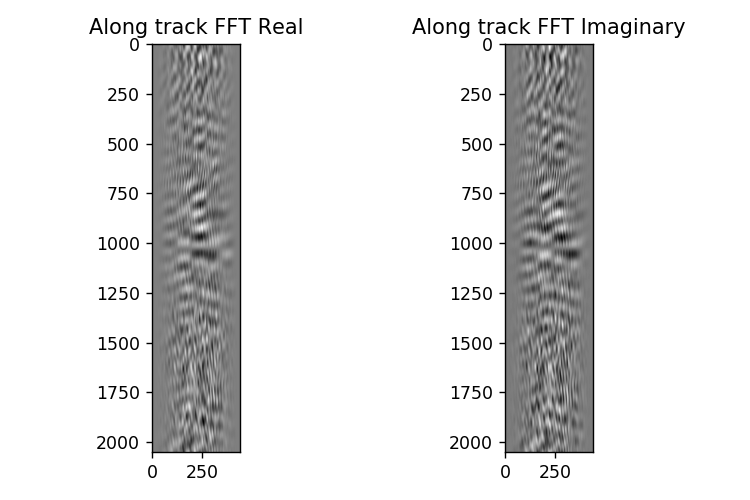

In [173]:
fig,ax=plt.subplots(1,2,figsize=(6,4))
ax[0].imshow(np.real(S),cmap='gray')
ax[0].set_title('Along track FFT Real')
ax[1].imshow(np.imag(S),cmap='gray')
ax[1].set_title('Along track FFT Imaginary')
fig.tight_layout()
fig.savefig('Along_track_fft')

In [175]:
#There's a matched filter step here that is for calibration targets only
#It didn't affect image processing 
S_mf=S*1


#Stolt interpolation
start=time.time()-FFT_time

#FOR DATA ANALYSIS
kstart =73;
kstop = 108.5;

#kstart = 95;
#kstop = 102;

Ky_even = np.linspace(kstart, kstop, 1024); #create evenly spaced Ky for interp for real data


Ky=np.zeros(S_mf.shape)
S_st=np.zeros((zpad,len(Ky_even)))+0*1j
for ii in np.arange(zpad):
    Ky[ii,:]=np.sqrt(Kr**2-Kx[ii]**2)
    S_st[ii,:]=np.interp(Ky_even, Ky[ii,:], S_mf[ii,:])
S_st[np.isnan(S_st)]=1e-30

print('Stolt Interpolation section complete at %f seconds'  %toc())
stolt_done=time.time()-start

Stolt Interpolation section complete at 0.455204 seconds


<IPython.core.display.Javascript object>


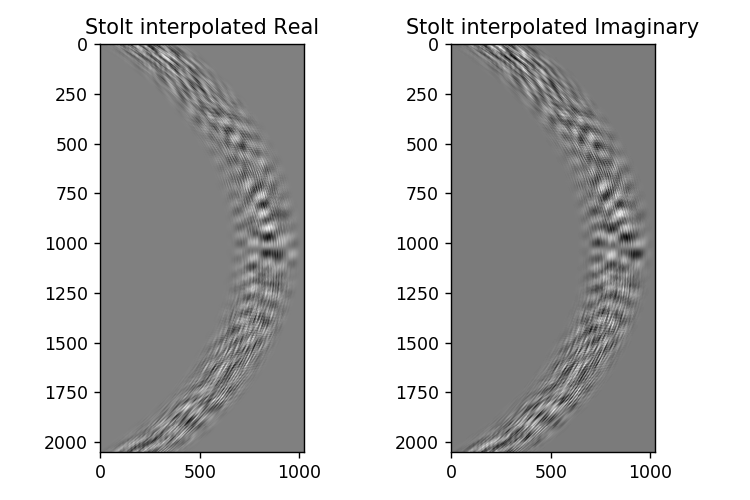

In [177]:
fig,ax=plt.subplots(1,2,figsize=(6,4))
ax[0].imshow(np.real(S_st),cmap='gray')
ax[0].set_title('Stolt interpolated Real')
ax[1].imshow(np.imag(S_st),cmap='gray')
ax[1].set_title('Stolt interpolated Imaginary')
fig.tight_layout()
fig.savefig('Stolt_interpolated_data')

In [179]:
#perform the inverse FFT's
start=time.time()-stolt_done

#new notation:  v(x,y), where x is crossrange
#first in the range dimmension
S_shape=S_st.shape
v=np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(S_st,axes=0),s=(4*S_shape[0],4*S_shape[1])),axes=0)
#This pads with zeros then performs the 2D-ifft

bw = c * (kstop-kstart)/(4*np.pi)
max_range= (c*S_shape[1])/(2*bw)*1/.3048 #(m)
#S_image=v.copy() #%edited to scale range to d^3/2 #Jason Note: edited from?
#S_image=np.swapaxes(v,0,1)
S_image=np.fliplr(np.rot90(v))
cr1 = -80; #%(ft) originally -80
cr2 = 80; #%(ft)
dr1 = 1 + Rs/.3048; #%(ft) #Reminder Rs is distance to cal target, set as 0
dr2 = 350 + Rs/.3048; #%(ft)

#data truncation
dr_index1 = round(float((dr1/max_range)*S_image.shape[0]));
dr_index2 = round(float((dr2/max_range)*S_image.shape[0]));
cr_index1 = round(float(( (cr1+zpad*delta_x/(2*.3048)) /(zpad*delta_x/.3048))*S_image.shape[1]));
cr_index2 = round(float(( (cr2+zpad*delta_x/(2*.3048))/(zpad*delta_x/.3048))*S_image.shape[1]));
trunc_image = S_image[dr_index1:dr_index2,cr_index1:cr_index2];
downrange = np.linspace(-1*dr1,-1*dr2, trunc_image.shape[0]) + Rs/.3048;
crossrange = np.linspace(cr1, cr2, trunc_image.shape[1]);

print('Data truncation complete at %f seconds' %toc())

#Do some range based scaling, divides by range^(3/2)
range_scaled=trunc_image*np.abs(downrange*.3048)[:,None]**(3/2)

def dbv(img):
    return 20*np.log10(np.abs(img))

db_scaled_image=dbv(range_scaled)[::-1,:]#They flip the image

Data truncation complete at 1.120108 seconds


<IPython.core.display.Javascript object>


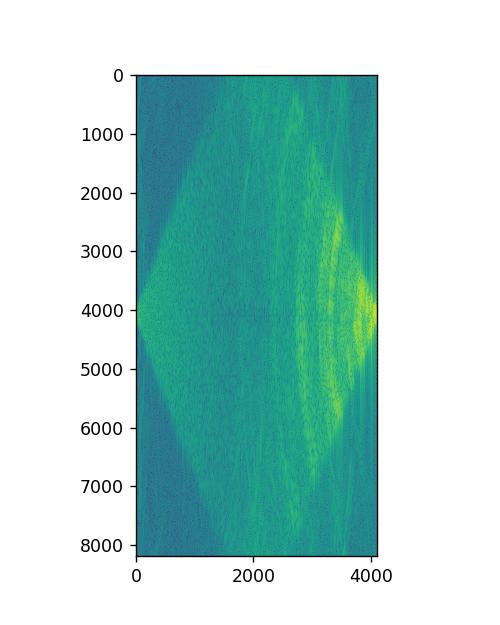

In [191]:
fig,ax=plt.subplots(figsize=(4,5))
ax.imshow(dbv(v))
fig.savefig('unflipped and not cropped')

<IPython.core.display.Javascript object>


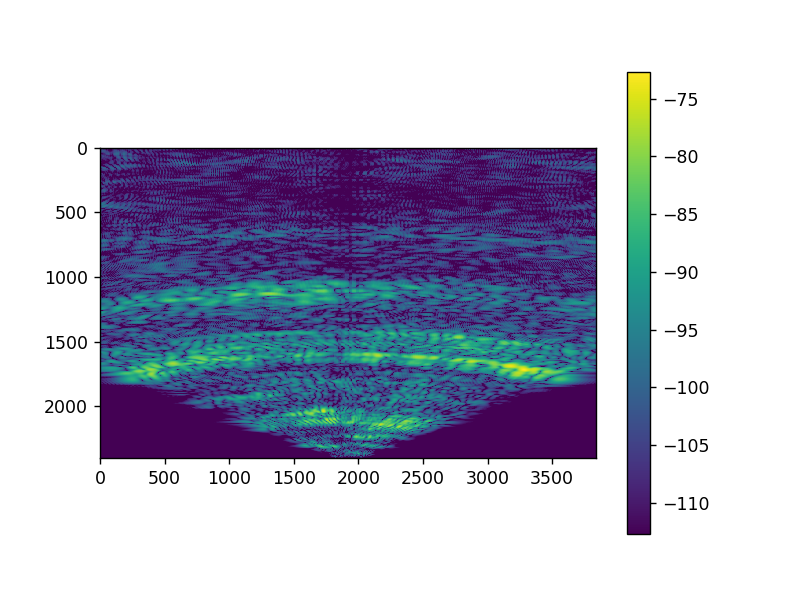

In [194]:
img=db_scaled_image.copy()
fig, ax = plt.subplots()
im=ax.imshow(img,vmin=img.max()-40, vmax=img.max())

#ax.set_xticks(crossrange)
#ax.set_yticks(downrange)
#im=ax.imshow(img)
fig.colorbar(im, ax=ax)
fig.savefig('final_image')

In [196]:
def toc(start): #This will help me speed up the code
        return time.time()-start
    
def dbv(img):
    return 20*np.log10(np.abs(img))
    
def build_image(filepath, verbose=False, hilb=False):
    start=time.time()
    
    if verbose: print('Program running, clock at %f seconds' %toc(start))
    fs, data=wavfile.read(filepath) #Sampling frequency, 2-channel data
    if verbose: print('Audioread completed at %f seconds' %toc(start))

    #Define constant
    c=299792458.0 #(m/s) speed of light
    
    #Define radar parameters
    T_p = 20e-3 #(s) Time length of pulse
    Trp = .25 #Minimum range profile time duration
    num_samp = int(np.floor(T_p*fs))
    fstart = 2260e6 #(Hz) LFM start frequency
    fstop = 2590e6 #(Hz) LFM stop frequency
    fc = (2590e6 - 2260e6)/2 + 2260e6; #(Hz) center radar frequency
    BW = fstop-fstart #(Hz) transmit bandwidth
    cr = BW/20e-3; #(Hz/sec) chirp rate
    

    freq= np.linspace(fstart,fstop,num_samp//2) #instantaneous transmit frequency

    #Invert the input... why I have no idea
    #Matlab autonormalizes and python doesn't, divide by 32767
    trig_channel=-1*data[:,0]/32767
    data_channel=-1*data[:,1]/32767
    if verbose: print('Input inversion completed at %f seconds' %toc(start))

    #Parse data here by position (silence between recorded data)
    #I don't like the way they did this and I think it could be much faster
    rpstart=np.abs(trig_channel)>np.mean(np.abs(trig_channel))

    No_data_length=int(np.floor(Trp*fs))
    rpstart[0]=True
    where_rp=rpstart.nonzero()[0]
    diff_rp=where_rp[1:]-where_rp[:-1]
    trigger_thresh=diff_rp>No_data_length
    npulses=np.sum(trigger_thresh) #Count the number of transmitter locations
    trigger_start=trigger_thresh.nonzero()[0]
    location_start=where_rp[trigger_start+1]

    data_parsed_loc=np.zeros((npulses,No_data_length))
    trig_parsed_loc=np.zeros((npulses,No_data_length))
    for i in range(npulses):
        data_parsed_loc[i,:]=data_channel[location_start[i]:location_start[i]+No_data_length]
        trig_parsed_loc[i,:]=trig_channel[location_start[i]:location_start[i]+No_data_length]
    if verbose: print('Parsed by position at %f seconds, %d pulses' %(toc(start), npulses))

    #Parse data by pulse, add coherant pulses
    thresh=0.08
    sif3=np.zeros((npulses,num_samp//2))+0*1j
    phase_hist=np.zeros((npulses,num_samp))
    test=np.zeros((npulses,100))
    for i in range(npulses):
        loc=trig_parsed_loc[i,:]
        dat=data_parsed_loc[i,:]
        loc_threshed=loc>thresh
        loc_thresh=(loc_threshed).nonzero()[0]
        loc_diff=loc_thresh[1:]-loc_thresh[:-1]
        loc_diff_index=(loc_diff>9).nonzero()[0]
        #loc_start=np.concatenate((np.array([0]),loc_diff))
        loc_start=loc_thresh[loc_diff_index+1]
        pulse=np.zeros(num_samp)
        chopped=0
        for pul in loc_start[loc_start<(len(loc)-2*num_samp)]:
            max_loc=np.argmax(loc[pul:pul+2*num_samp])
            max_here=np.argmax(loc[pul:pul+2])
            if max_loc==max_here:
                clip=dat[pul+max_loc:pul+max_loc+num_samp]
                pulse=pulse+clip
                test[i,chopped]=pul+max_here
                chopped=chopped+1

        phase_hist[i,:]=pulse/chopped
        # They say this is the hilbert transform, I don't see why
        q=np.fft.ifft(pulse/chopped)
        sif3[i,:]=np.fft.fft(q[len(q)//2:])

    #things happen so...
    phase_hist[np.isnan(phase_hist)]=1e-30
    if hilb: 
        sif3=hilbert(phase_hist,axis=1)
    sif3[np.isnan(sif3)]=1e-30
    halfsamples=sif3.shape[1]

    if verbose: print('SAR data ready at %f seconds' %toc(start))
    
    #Maybe they are trying to subtract the mean?
    s2=sif3-np.mean(sif3,axis=0)[None,:]

    #radar parameters
    
    #VERY IMPORTANT, change Rs to distance to cal target
    #Rs = (12+9/12)*.3048; #(m) y coordinate to scene center (down range), make this value equal to distance to cal target
    Rs = 0;
    delta_x = 2*(1/12)*0.3048; #(m) 2 inch antenna spacing
    L = delta_x*(npulses); #(m) aperture length
    t = np.linspace(0, T_p, halfsamples); #(s) fast time, CHECK SAMPLE RATE
    Kr = np.linspace(((4*np.pi/c)*(fc - BW/2)), ((4*np.pi/c)*(fc + BW/2)), (len(t)));

    if verbose: print('Phase 1 of processing took %f seconds' %toc(start))
    
    #PHASE 2 Processing
    #Apply hanning window
    N=s2.shape[1]
    H=np.zeros(N)
    for ii in range(N):
        H[ii]=.5+.5*np.cos(2*np.pi*(ii+1-N/2)/N)

    sif_h=s2*H[None,:]

    #%along track FFT (in the slow time domain)
    #%first, symetrically cross range zero pad so that the radar can squint
    zpad = 2048; #%cross range symetrical zero pad
    szeros=np.zeros((zpad,N))+0*1j
    index=int(np.ceil((zpad-npulses)/2))
    szeros[index:index+npulses,:]=sif_h

    S=np.fft.ifftshift(np.fft.fft(np.fft.fftshift(szeros),axis=0))
    Kx=np.linspace((-np.pi/delta_x),(np.pi/delta_x),S.shape[0])

    if verbose: print('Along track FFT section complete at %f seconds' %toc(start))
        
    S_mf=S*1

    #FOR DATA ANALYSIS
    kstart =73;
    kstop = 108.5;

    #kstart = 95;
    #kstop = 102;

    Ky_even = np.linspace(kstart, kstop, 1024); #create evenly spaced Ky for interp for real data


    Ky=np.zeros(S_mf.shape)
    S_st=np.zeros((zpad,len(Ky_even)))+0*1j
    for ii in np.arange(zpad):
        Ky[ii,:]=np.sqrt(Kr**2-Kx[ii]**2)
        S_st[ii,:]=np.interp(Ky_even, Ky[ii,:], S_mf[ii,:])
    S_st[np.isnan(S_st)]=1e-30

    if verbose: print('Stolt Interpolation section complete at %f seconds'  %toc(start))
        
    #new notation:  v(x,y), where x is crossrange
    #first in the range dimmension
    S_shape=S_st.shape
    v=np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(S_st,axes=0),s=(4*S_shape[0],4*S_shape[1])),axes=0)
    #This pads with zeros then performs the 2D-ifft

    bw = c * (kstop-kstart)/(4*np.pi)
    max_range= (c*S_shape[1])/(2*bw)*1/.3048 #(m)
    #S_image=v.copy() #%edited to scale range to d^3/2 #Jason Note: edited from?
    #S_image=np.swapaxes(v,0,1)
    S_image=np.fliplr(np.rot90(v))
    cr1 = -80; #%(ft) originally -80
    cr2 = 80; #%(ft)
    dr1 = 1 + Rs/.3048; #%(ft) #Reminder Rs is distance to cal target, set as 0
    dr2 = 350 + Rs/.3048; #%(ft)

    #data truncation
    dr_index1 = round(float((dr1/max_range)*S_image.shape[0]));
    dr_index2 = round(float((dr2/max_range)*S_image.shape[0]));
    cr_index1 = round(float(( (cr1+zpad*delta_x/(2*.3048)) /(zpad*delta_x/.3048))*S_image.shape[1]));
    cr_index2 = round(float(( (cr2+zpad*delta_x/(2*.3048))/(zpad*delta_x/.3048))*S_image.shape[1]));
    trunc_image = S_image[dr_index1:dr_index2,cr_index1:cr_index2];
    downrange = np.linspace(-1*dr1,-1*dr2, trunc_image.shape[0]) + Rs/.3048;
    crossrange = np.linspace(cr1, cr2, trunc_image.shape[1]);

    if verbose: print('Data truncation complete at %f seconds' %toc(start))

    #Do some range based scaling, divides by range^(3/2)
    range_scaled=trunc_image*np.abs(downrange*.3048)[:,None]**(3/2)
    
    #Convert to decibels, then flip
    db_scaled_image=dbv(range_scaled)[::-1,:]#They flip the image
    return db_scaled_image

<IPython.core.display.Javascript object>


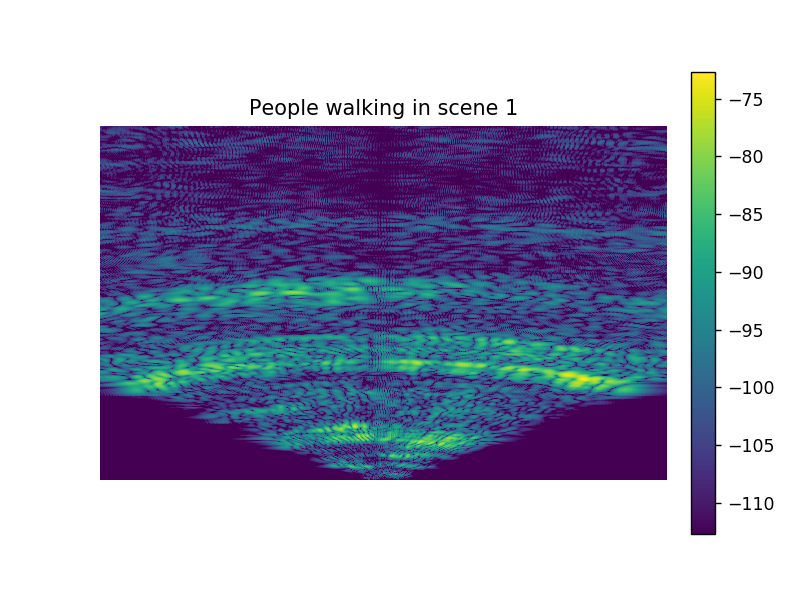

In [218]:
#filepath='maybenomotion.wav'
#filepath='radarslipped.wav'
#filepath='sar1motioninfield.wav'
#filepath='sar2motioninfield.wav'
#img2=build_image(filepath, verbose=True,hilb=True)
img=build_image(filepath, verbose=False,hilb=False)
fig, ax = plt.subplots()
im=ax.imshow(img,vmin=img.max()-40, vmax=img.max())
ax.axis('off')
ax.set_title('People walking in scene 1')
fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
fig.savefig(filepath.strip('.wav'))

In [207]:
filepath.strip('.wav')

'sar2motioninfield'

<IPython.core.display.Javascript object>


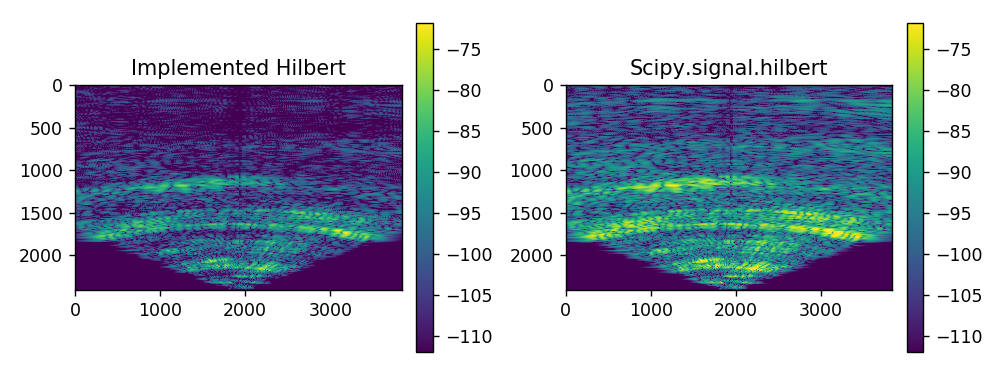

In [148]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
im=ax[0].imshow(img,vmin=img.max()-40, vmax=img.max())
ax[0].set_title('Implemented Hilbert')
#ax[0].axis('off')
im2=ax[1].imshow(img2,vmin=img.max()-40, vmax=img.max())
ax[1].set_title('Scipy.signal.hilbert')
#ax[1].axis('off')
fig.colorbar(im, ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[1],fraction=0.046, pad=0.04)
fig.tight_layout()
#fig.savefig('Hilbert_compare')

In [224]:
c/(2*BW/num_samp)

400.6317393272727

In [222]:
c/(2*BW)

0.454230996969697

In [231]:
(c/(2.315e9))/(2*np.arctan(((1/6)*.3048)/400))

509.84245099876557

In [232]:
(c/(fc))/(2*np.arctan(60*((1/6)*.3048)/400))

8.112083240880619

In [12]:
c*(22050/(2*cr))

200.31586966363636